In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

Carregar os dados da fonte e retirar linhas com conteúdo 'TOTAL', pois não serão utilizadas

In [3]:
url = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'
df = pd.read_csv(url, usecols=['date','state','deathsMS','totalCasesMS'])
df = df[df['state'] != 'TOTAL'].reset_index().drop(columns='index')

Criar df_seqcom todas as datas e o sequencial numérico

In [4]:
df_seq = df.drop(columns=['state','deathsMS','totalCasesMS'])
df_seq = df_seq.groupby('date').agg('max').reset_index(col_level=0)
df_seq['seq'] = df_seq.index
df_seq.head()


date  seq
0  2020-02-25    0
1  2020-02-26    1
2  2020-02-27    2
3  2020-02-28    3
4  2020-02-29    4

Criar lista de estados para definir a região

In [5]:
sul = ['PR','SC','RS']
sudeste = ['MG','SP','RJ','ES']
centro = ['MS','MT','GO','DF']
nordeste = ['PI','CE','MA','RN','PB','PE','AL','SE','BA']
norte = ['RO','AC','AM','RR','PA','AP','TO']

todos_estados = sul + sudeste + centro + nordeste + norte

len(todos_estados)

27

Criar df_estado_data contendo dias X estados

In [6]:
df_estado_data = pd.DataFrame(columns=['state','date'])
for i in range(len(todos_estados)):
    df_new = pd.DataFrame({'state': todos_estados[i]}, df_seq['date']).reset_index(col_level=0)
    df_estado_data = df_estado_data.append(df_new)
df_estado_data.shape[0]


1269

Mergear a df fonte com a df_estado_data e adicionar 0 para os campos NAN

In [7]:
df = df.merge(df_estado_data, how='right', left_on=['date','state'], right_on=['date','state']).sort_values(by='date', ascending=True)
df = df.fillna(0)
df.shape[0]

1269

Inserir a coluna region e inserir os valores referente a região

In [8]:
df['region'] = ''
for i in range(df.shape[0]):
    if df['state'][i] in sul:
        df['region'][i] = 'Sul'
    elif df['state'][i] in sudeste:
        df['region'][i] = 'Sudeste'
    elif df['state'][i] in centro:
        df['region'][i] = 'Centro-Oeste'
    elif df['state'][i] in nordeste:
        df['region'][i] = 'Nordeste'
    else:
        df['region'][i] = 'Norte'
    
df.head()

date state  deathsMS  totalCasesMS        region
0    2020-02-25    SP       0.0           0.0       Sudeste
853  2020-02-25    MG       0.0           0.0       Sudeste
865  2020-02-25    RJ       0.0           0.0       Sudeste
874  2020-02-25    ES       0.0           0.0       Sudeste
884  2020-02-25    MS       0.0           0.0  Centro-Oeste

Mergear a df fonte com a df_seq com os sequenciais de data

In [9]:
df = df.merge(df_seq, left_on='date', right_on='date')
df.head(10)
qtd_dias = df['seq'].max()
qtd_dias

46

Criar um dict com as regiões e as cores para o gráfico 

In [10]:
colors = dict(zip(
    ["Sul", "Norte", "Sudeste", "Nordeste", "Centro-Oeste"],
    ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#f7bb5f"]
))
group_lk = df.set_index('state')['region'].to_dict()

In [11]:
dff = df[df['date'].eq('2020-04-10')].sort_values(by=['totalCasesMS','state'], ascending=True).tail(10)
dff.head(10)

date state  deathsMS  totalCasesMS    region  seq
1233  2020-04-10    BA      19.0         604.0  Nordeste   45
1219  2020-04-10    RS      14.0         636.0       Sul   45
1216  2020-04-10    PR      25.0         643.0       Sul   45
1220  2020-04-10    PE      65.0         684.0  Nordeste   45
1221  2020-04-10    SC      18.0         693.0       Sul   45
1239  2020-04-10    MG      17.0         698.0   Sudeste   45
1231  2020-04-10    AM      50.0         981.0     Norte   45
1240  2020-04-10    CE      58.0        1478.0  Nordeste   45
1217  2020-04-10    RJ     147.0        2464.0   Sudeste   45
1226  2020-04-10    SP     540.0        8216.0   Sudeste   45

Gerar os dados para plotar o gráfico. 
A def draw_barchart recebe o sequencial numérico do dia e plota o gráfico referente a ele

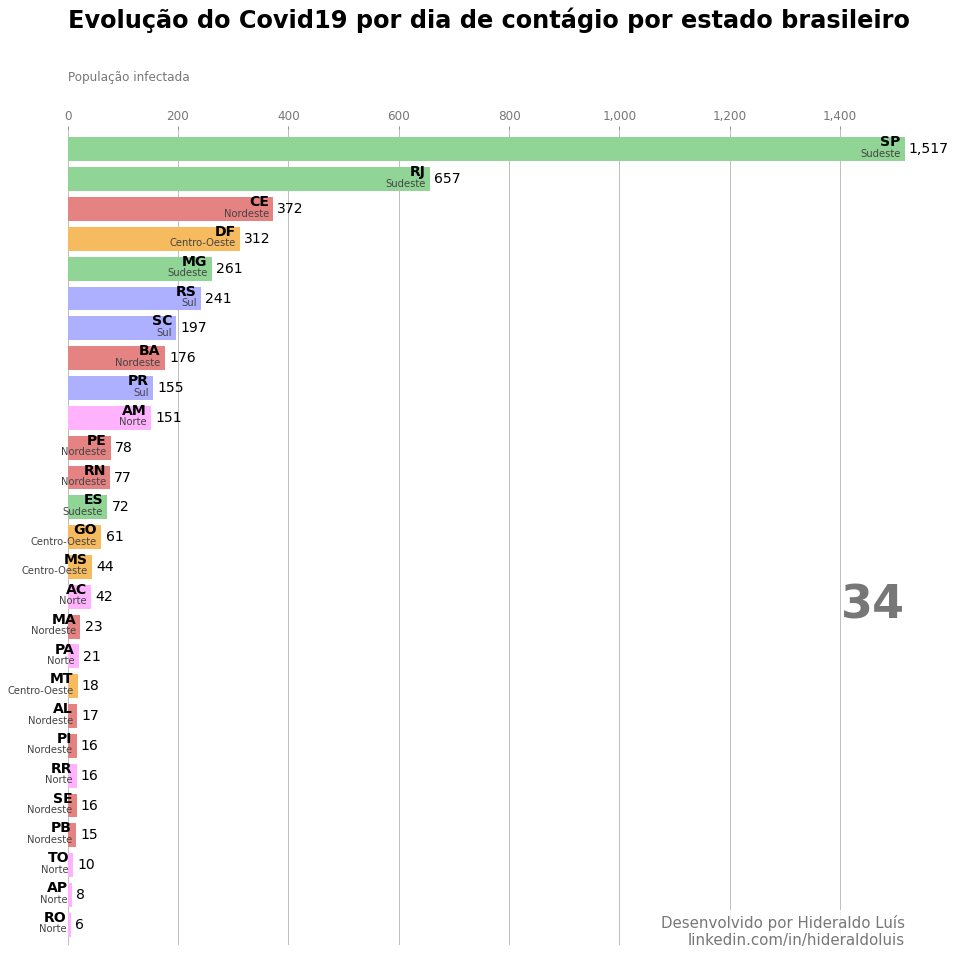

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

def draw_barchart(current_seq):
    dff = df[df['seq'].eq(current_seq)].sort_values(by=['totalCasesMS','state'], ascending=[True,False])#.tail(10)
    dff.head(10)
    ax.clear()
    ax.barh(dff['state'], dff['totalCasesMS'], color=[colors[group_lk[x]] for x in dff['state']])
    dx = dff['totalCasesMS'].max() / 200

    for i, (value, name) in enumerate(zip(dff['totalCasesMS'], dff['state'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')

    ax.text(1, 0.4, current_seq, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'População infectada', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Evolução do Covid19 por dia de contágio por estado brasileiro',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'Desenvolvido por Hideraldo Luís\nlinkedin.com/in/hideraldoluis', 
            transform=ax.transAxes, color='#777777', ha='right',
            size=15, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(34)

Para gerar a animação é usado o matplotlib.animation chamando a draw_barchart onde cada frame é um sequencial numérico de data

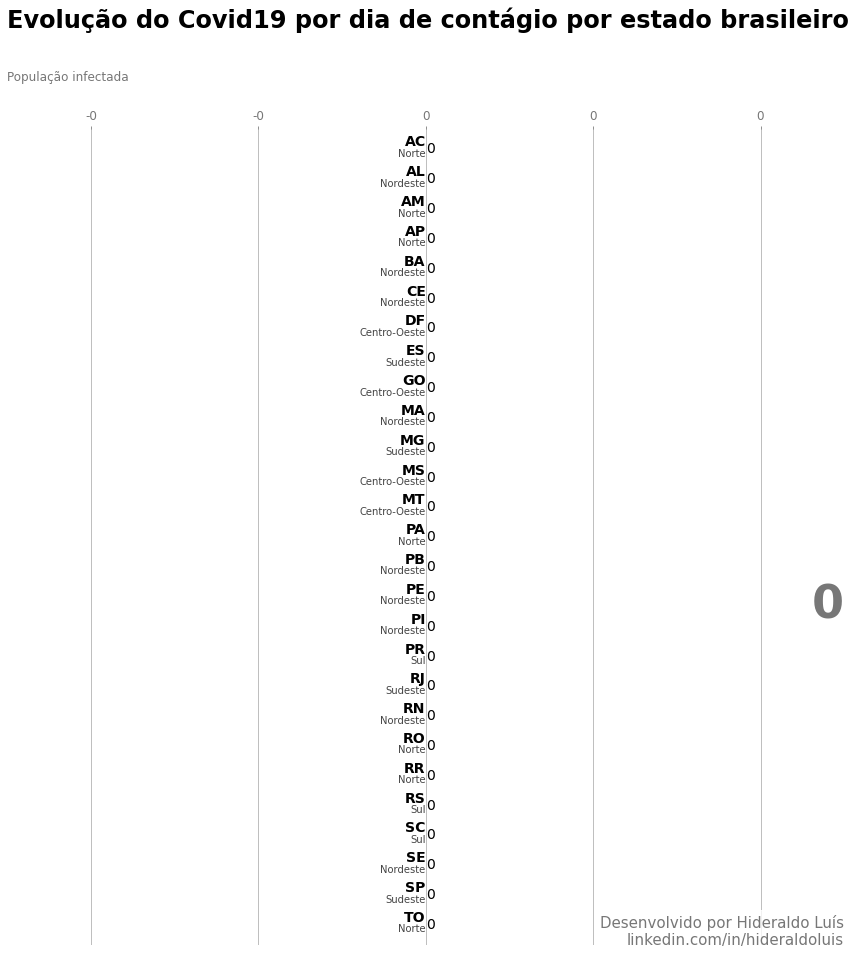

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0, qtd_dias), interval=400)
HTML(animator.to_jshtml())

No mesmo objeto matplotlib.animation é realizada a exportação para gif

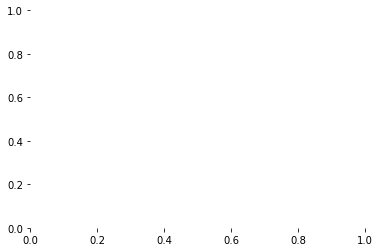

In [14]:
f = r"covid_gif.gif" 
writergif = animation.PillowWriter(fps=2) 
animator.save(f, writer=writergif)

Tendo o previamente instalado o ffmpeg é possível exportar como .mp4

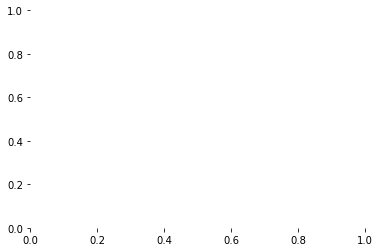

In [16]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

animator.save('covid_mp4.mp4', writer=writer)
